## Mask R-CNN FBS Model
Code and visualizations to test, debug and evaluate trained model

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import skimage.color
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
model_path = 'mask_rcnn/fbs_resnet50_da_tf_nominimask_1channel20190319T1724/mask_rcnn_fbs_resnet50_da_tf_nominimask_1channel_0070.h5'

WEIGHT_PATH = os.path.join(MODEL_DIR, model_path)

log(WEIGHT_PATH)

/home/alejandrovaldes/projects/fetal-brain-segmentation/logs/mask_rcnn/fbs_resnet50_da_tf_nominimask_1channel20190319T1724/mask_rcnn_fbs_resnet50_da_tf_nominimask_1channel_0070.h5


Using TensorFlow backend.


## Configurations

In [2]:
from fbs import FBSConfig

class InferenceConfig(FBSConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    MASK_SHAPE = [56, 56]

config = InferenceConfig()
config.display()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17494530969163263595
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10008041882
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14588873615009085271
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]

Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [5]:
from fbs import FBSDataset
DATASET_DIR = os.path.join(ROOT_DIR, 'data/')
dataset = FBSDataset()
dataset.load_data(DATASET_DIR, subset='validate')
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading data: 100%|██████████| 43/43 [00:47<00:00,  1.08s/it]

Images: 1858
Classes: ['BG', 'brain']


## Load Model

In [6]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR,
                             config=config)
    
print("Loading weights ", WEIGHT_PATH)
model.load_weights(WEIGHT_PATH, by_name=True)

Loading weights  /home/alejandrovaldes/projects/fetal-brain-segmentation/logs/mask_rcnn/fbs_resnet50_da_tf_nominimask_1channel20190319T1724/mask_rcnn_fbs_resnet50_da_tf_nominimask_1channel_0070.h5
Re-starting from epoch 70


## Run Detection

image ID: MRI.1320 (1320)


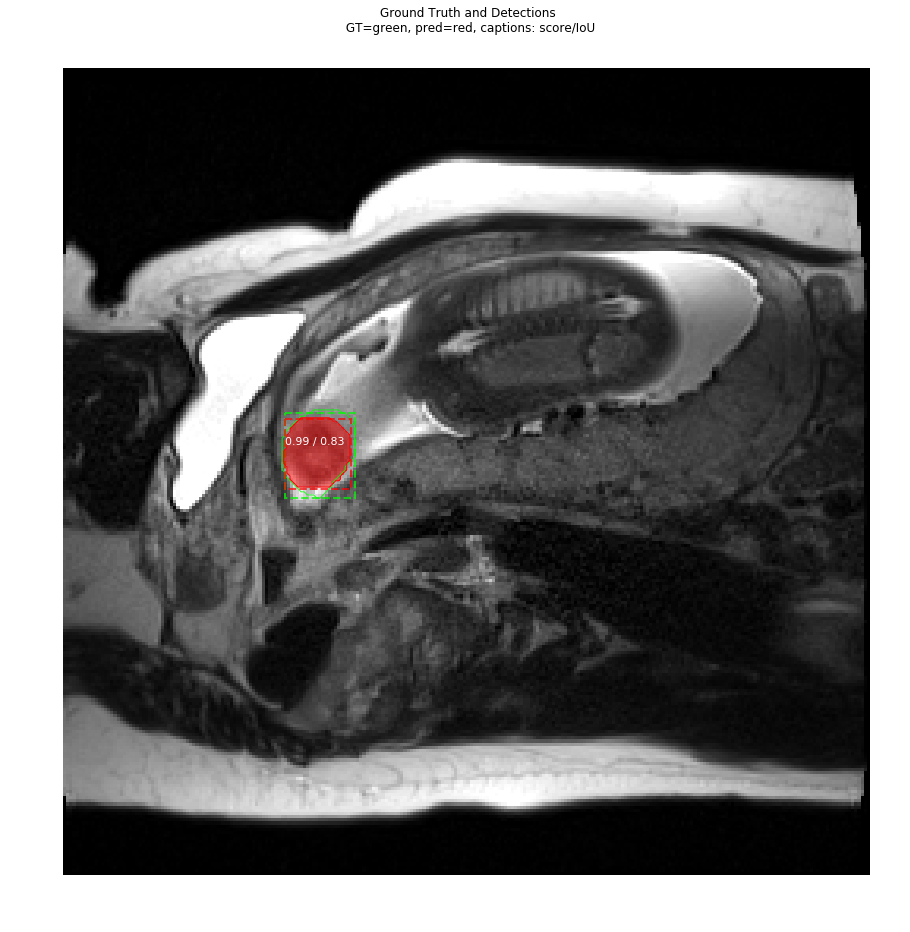

In [206]:
image_id = random.choice(dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({})".format(info["source"], info["id"], image_id))
# Run object detection
results = model.detect([image], verbose=0)

# Display results
r = results[0]

image = np.squeeze(image)
image = skimage.color.gray2rgb(image)  

pred_bbox = r['rois'] if gt_bbox.shape[0] > 0 else gt_bbox

visualize.display_differences(image, gt_bbox,
        gt_class_id, gt_mask, pred_bbox,
        r['class_ids'], r['scores'],
        r['masks'], dataset.class_names,
        show_box=True)
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)


## Precision-Recall

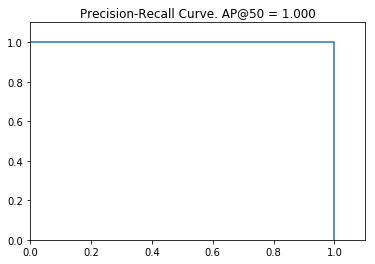

In [8]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

## Compute mAP @ IoU=50 on Batch of Images

In [9]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)

        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        #TODO FIX
        if len(gt_bbox) == 0 and len(r['rois']) == 1:
            APs.append(0)
            break
            
            
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.75


## Step by Step Prediction

## Stage 1: RPN
The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high objectness score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

## 1.a RPN Targets
The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [10]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (16320, 4)            min:  -91.00000  max:  315.00000  int32
target_rpn_match         shape: (16320,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (64, 4)               min:   -1.98841  max:    0.85938  float64
positive_anchors         shape: (2, 4)                min:   64.00000  max:  176.00000  int32
negative_anchors         shape: (62, 4)               min:  -11.00000  max:  264.00000  int32
neutral anchors          shape: (16256, 4)            min:  -91.00000  max:  315.00000  int32
refined_anchors          shape: (2, 4)                min:   80.00000  max:  169.00000  float32


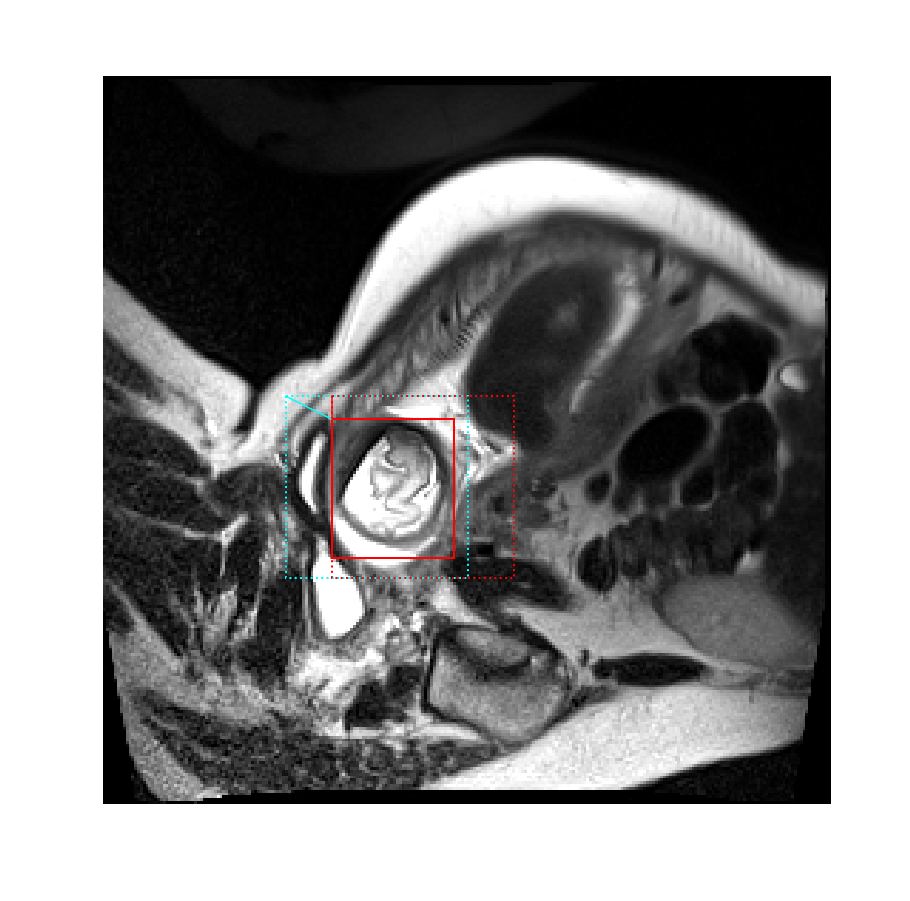

In [11]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
o_image = image
image = np.squeeze(image)
image = skimage.color.gray2rgb(image)
    
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

## 1.b RPN Predictions

In [12]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")
print(o_image.shape)
rpn = model.run_graph(o_image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

(256, 256, 1)
rpn_class                shape: (1, 16368, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35494  max:    1.22945  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.84754  max:    2.04135  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (2000,)               min:    0.00000  max: 3411.00000  int32
proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


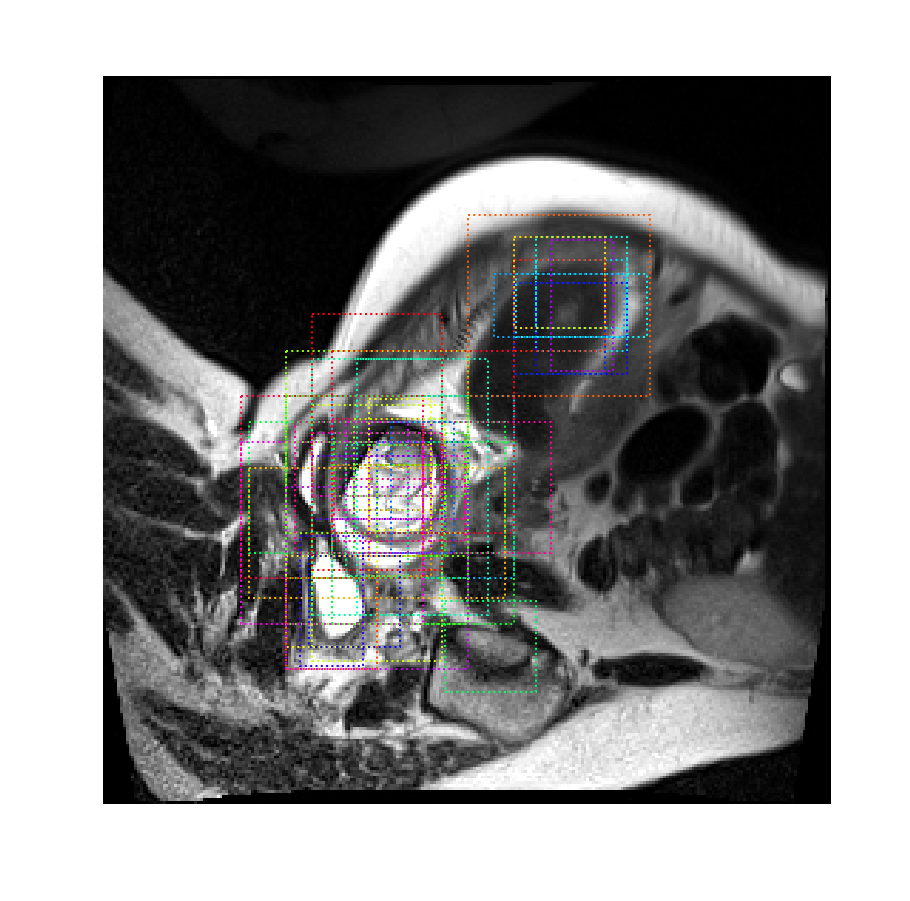

In [13]:
# Show top anchors by score (before refinement)
limit = 50
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

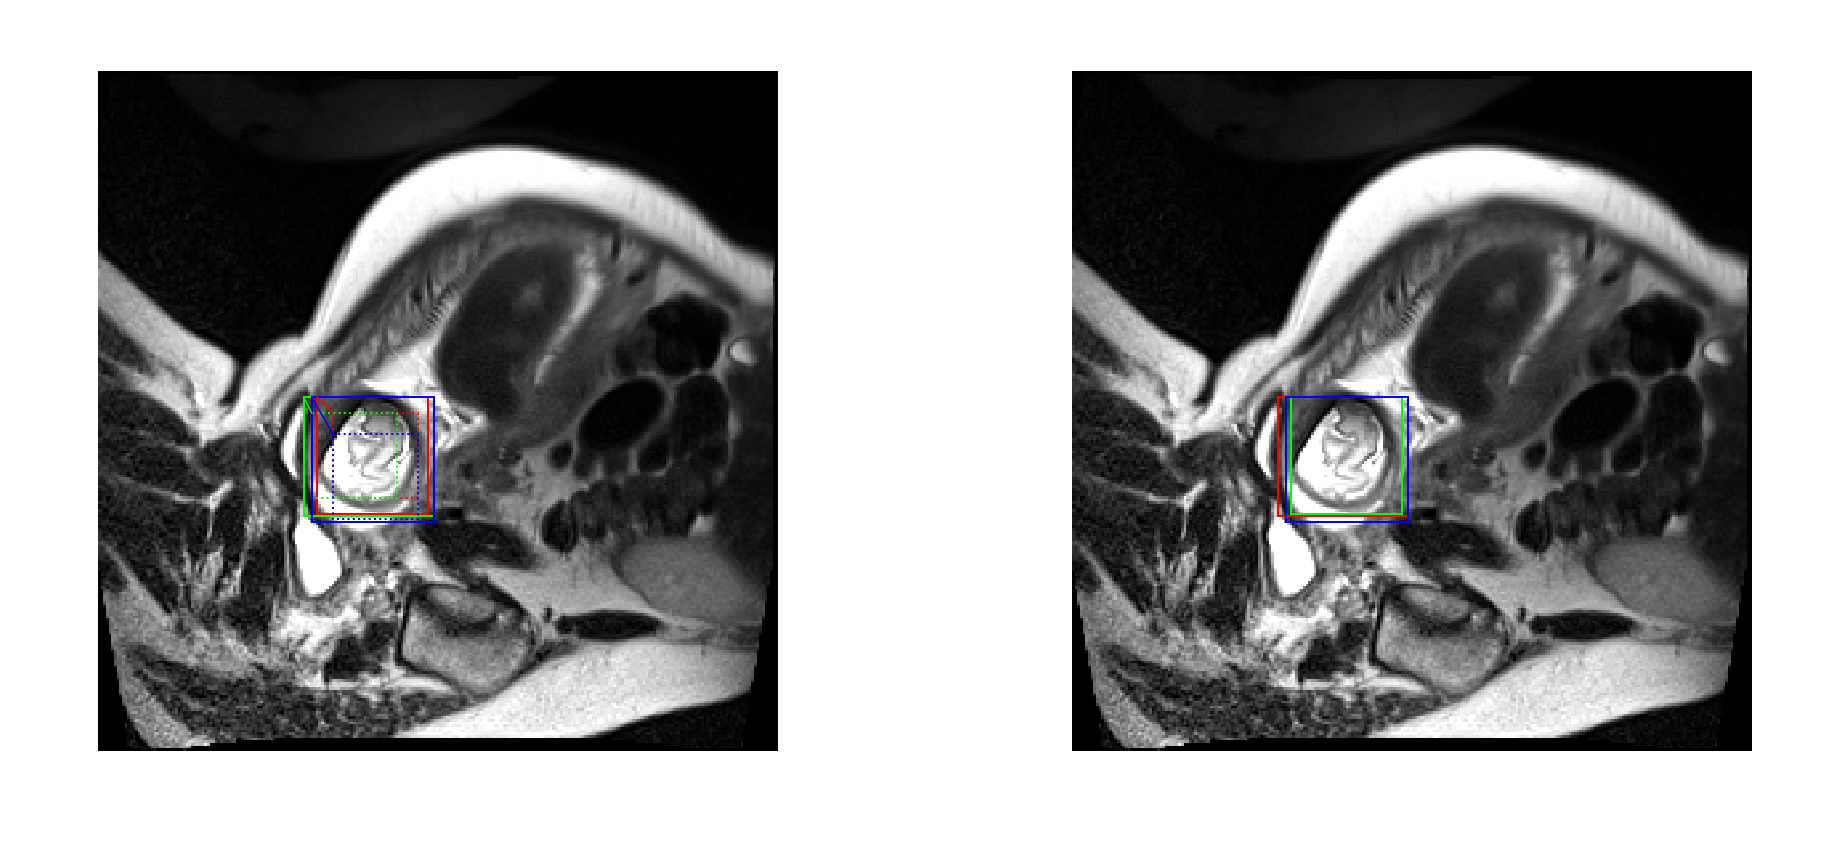

In [14]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 3
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

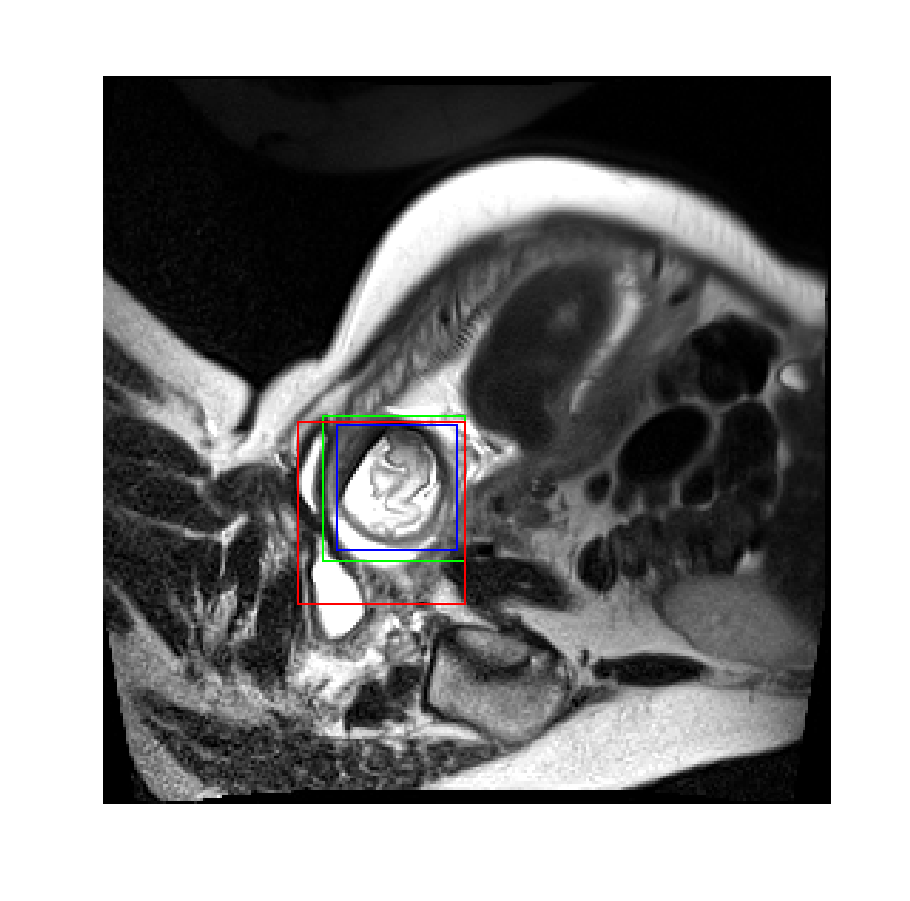

In [15]:
# Show refined anchors after non-max suppression
limit = 3
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

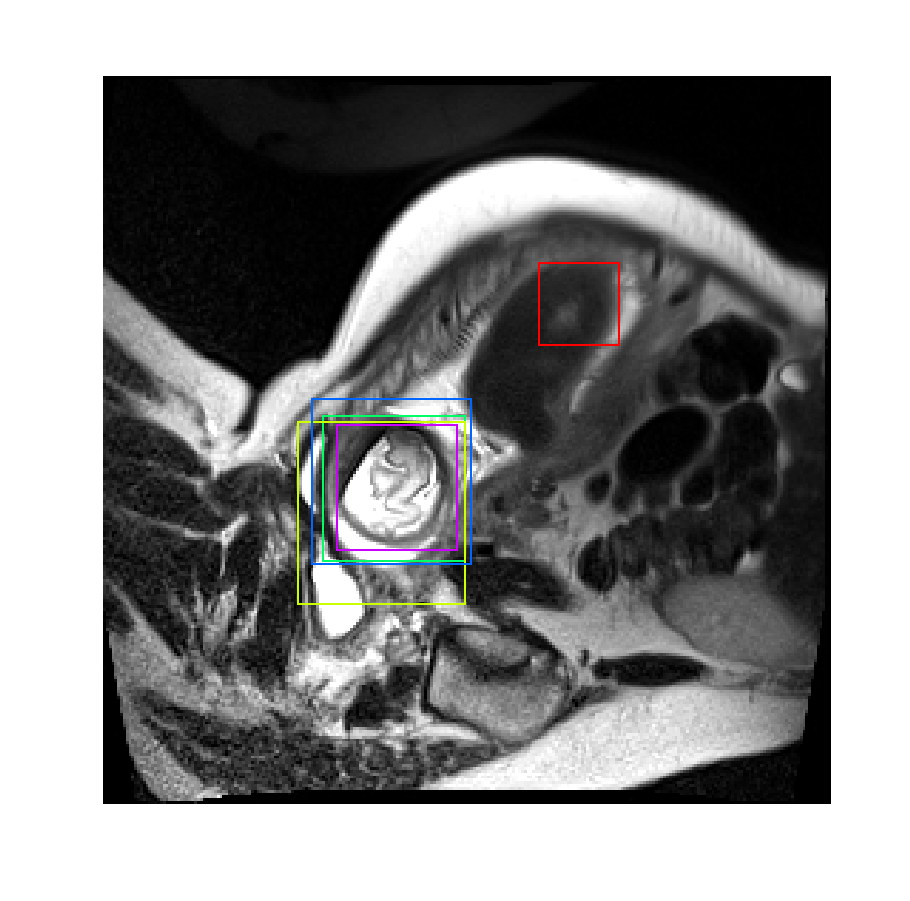

In [16]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 5
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

## Stage 2: Proposal Classification
This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions

In [17]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([o_image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 2000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 2000, 2, 4)       min:   -4.20654  max:    3.49203  float32
masks                    shape: (1, 1, 56, 56, 2)     min:    0.00007  max:    1.00000  float32
detections               shape: (1, 1, 6)             min:    0.31269  max:    1.00000  float32


1 detections: ['brain']


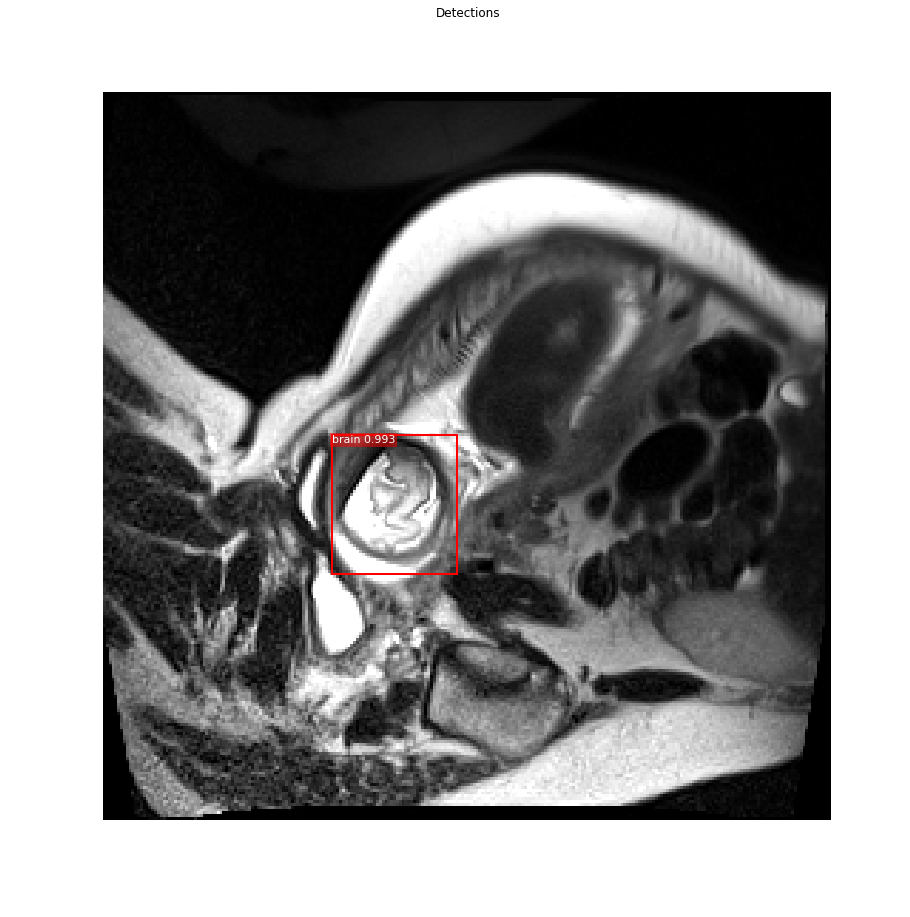

In [18]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = len(det_class_ids)
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

## 2.c Step by Step Detection

In [19]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1952 Valid proposals out of 2000
29 Positive ROIs
[('BG', 1971), ('brain', 29)]


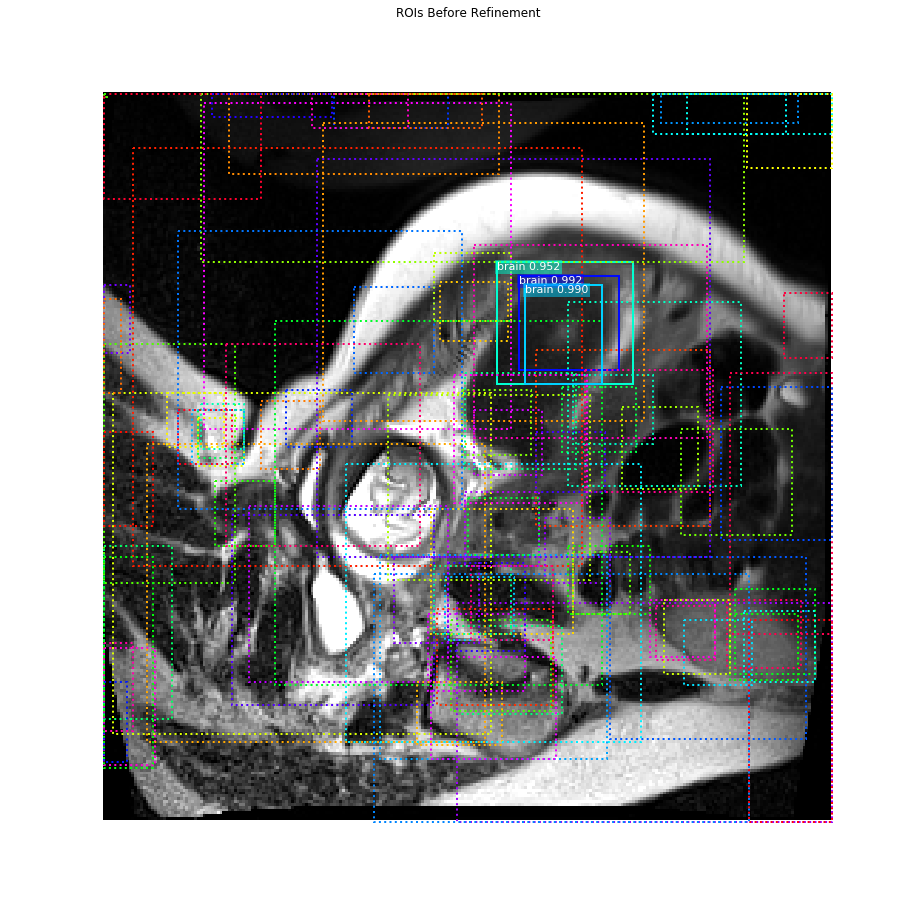

In [20]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 100
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (2000, 4)             min:   -4.20654  max:    1.51463  float32
refined_proposals        shape: (2000, 4)             min:   -0.13332  max:    0.99772  float32


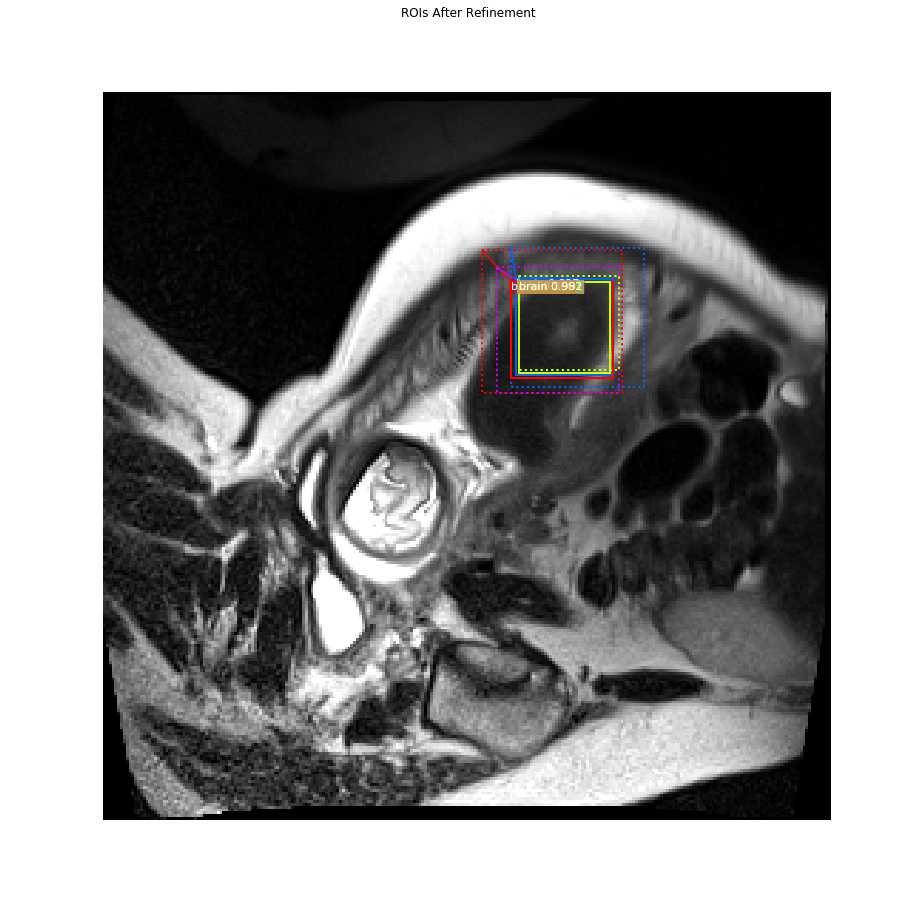

In [21]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")


#### Filter Low Confidence Detections

In [22]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 29 detections:
[   0    1    2    3    4    5    6    7    8    9   10   11   13   16
   17   18   19   24   27   40   41   57   61   73   90  128  708  991
 1256]


In [23]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0 confidence. Keep 29:
[   0    1    2    3    4    5    6    7    8    9   10   11   13   16
   17   18   19   24   27   40   41   57   61   73   90  128  708  991
 1256]


#### Per-Class Non-Max Suppression

In [24]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

brain                 : [   0    1    2    3    4    5    6    7    8    9   10   11   13   16
   17   18   19   24   27   40   41   57   61   73   90  128  708  991
 1256] -> [7 9]

Kept after per-class NMS: 2
[7 9]


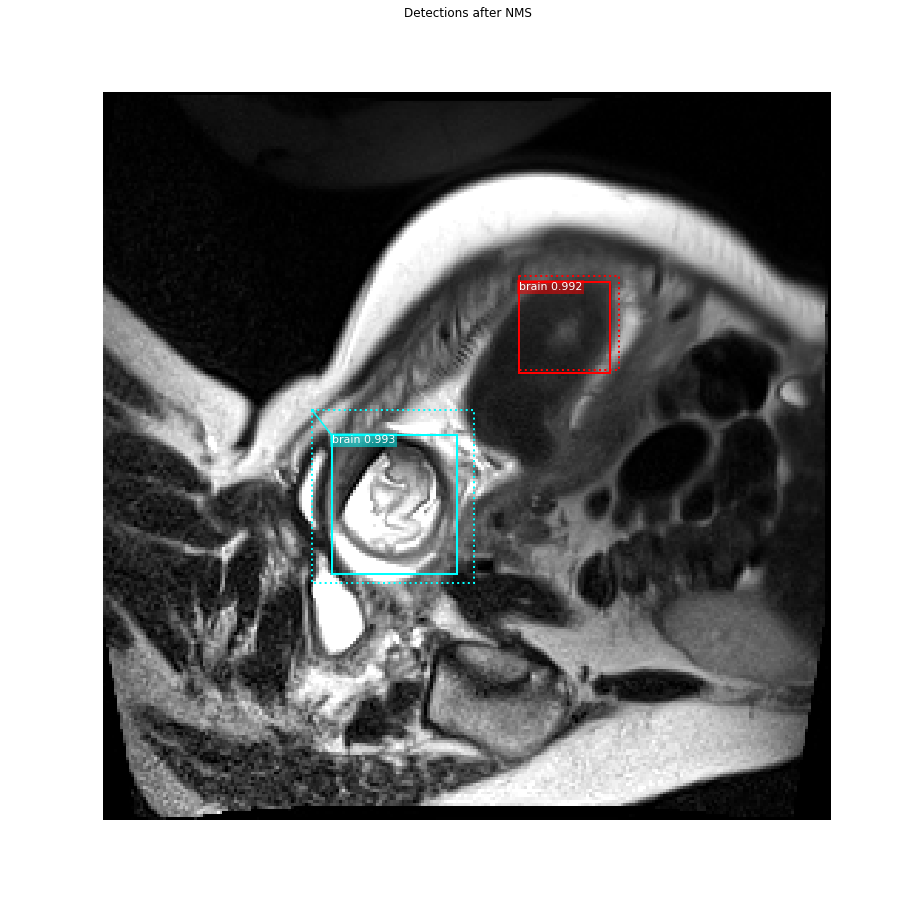

In [25]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

### Stage 3: Generating Masks
This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

#### 3.a Mask Targets

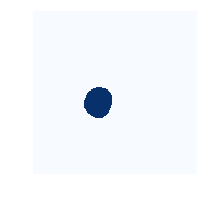

In [26]:
limit = 1
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

#### 3.b Predicted Masks

In [27]:
# Get predictions of mask head
mrcnn = model.run_graph([o_image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = len(det_class_ids)
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 1, 6)             min:    0.31269  max:    1.00000  float32
masks                    shape: (1, 1, 56, 56, 2)     min:    0.00007  max:    1.00000  float32
1 detections: ['brain']


In [28]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (1, 56, 56)           min:    0.00007  max:    1.00000  float32
det_masks                shape: (1, 256, 256)         min:    0.00000  max:    1.00000  bool


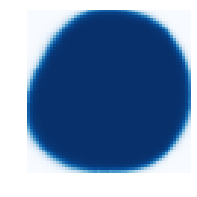

In [29]:
display_images(det_mask_specific * 255, cmap="Blues", interpolation="none")

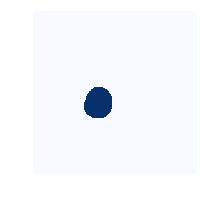

In [30]:
display_images(det_masks * 255, cmap="Blues", interpolation="none")

### Visualize Activations

In [31]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 256, 256, 1)      min:  -73.99000  max:  181.00999  float32
res2c_out                shape: (1, 64, 64, 256)      min:    0.00000  max:   17.95751  float32
res3c_out                shape: (1, 32, 32, 512)      min:    0.00000  max:   14.77052  float32
rpn_bbox                 shape: (1, 16368, 4)         min:  -13.71232  max:   35.41114  float32
roi                      shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


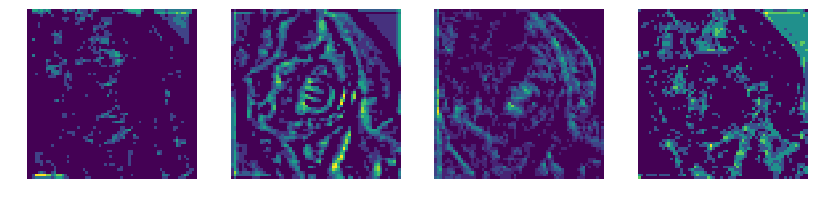

In [32]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

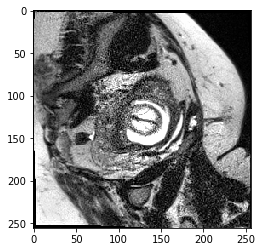

In [33]:
# Input image (normalized)
activation_image = skimage.color.gray2rgb(activations["input_image"][0]).squeeze()
_ = plt.imshow(modellib.unmold_image(activation_image,config))

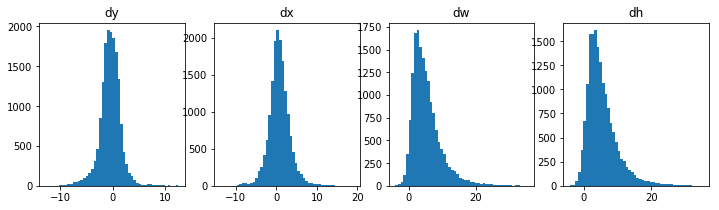

In [34]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

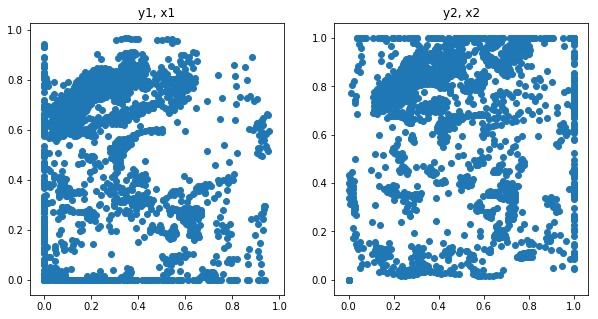

In [35]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()